# Préparez des données pour un organisme de santé publique

## Santé publique France

![Santé Publique France](data/images/Sante-publique-France-logo.png)

L'agence "Santé publique France" a lancé un appel à projets pour rendre les données de santé plus accessibles. L’agence souhaite faire explorer et visualiser des données, pour que ses agents puissent les exploiter.


## Open Food Facts

![Open Food Facts](data/images/OpenFoodFacts.png)

À l’aide des données d’Open Food Facts, nous réaliserons une première exploration et visualisation des données, afin que les agents puissent ensuite s’appuyer sur nos résultats.

### Importations

Importation de bibliothèques et des paramètres.

In [1]:
# Manipulation de données
import warnings
import folium
from IPython import get_ipython
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from branca.colormap import LinearColormap

# Afficher toutes les sorties de cellule
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

ipython = get_ipython()

# extension de chargement automatique
# if 'autoreload' not in ipython.extension_manager.loaded:
#     %load_ext autoreload

# %autoreload 2

warnings.filterwarnings('ignore')

### Fonctions

Fonctions commune

In [2]:
# Calculer le nombre de lignes d'un dataframe spécifique
def get_rows(df):
    rows = df.shape[0]
    return rows


# Retourner les 10 premiers enregistrements par nom de colonne
def get_top_10(df, column_name):
    df_result = df.groupby([
        column_name
    ]).size().reset_index(name='Nombre').sort_values('Nombre',
                                                     ascending=False).head(10)

    rows = get_rows(df)
    df_result['Pourcentage'] = df_result['Nombre'] / rows * 100

    return df_result.copy()


# Compter le nombre de lignes vides pour un dataframe spécifique.
def get_empty_rows(df, column_name):
    return df.query(str(column_name) + '.isnull()').count()


# Afficher le graphique en barre avec le nombre


def show_plot(df, column_name):
    df_plot = df.loc[:, [column_name, 'Nombre']].set_index(
        column_name)['Nombre'].copy()

    plt.figure(figsize=(15, 10))

    sns.set(style="whitegrid")
    g = sns.barplot(df_plot, df_plot.index, orient='h', palette="Blues_d")

    plt.title('Les plus grands ' + column_name, fontsize=20)
    plt.xlabel("Nombre d'occurrences", fontsize=14)
    plt.ylabel(column_name, fontsize=14)

    # Show Number on the right of the bar plot
    for i, v in enumerate(df_plot.values.tolist()):
        g.text(v + 3, i + .25, str(v), color='black', fontweight='normal')

    plt.show()


# Imprimer les principaux éléments de statistiques
def print_stats(df, column_name):
    total_rows = get_rows(df)
    empty_rows = str(df[column_name].isna().sum())
    perc = int(empty_rows) * 100 / int(total_rows)
    print("Nombre d'enregistrements vides pour " + str(column_name) + ': ' +
          str(empty_rows) + ' (' + str(perc) + '%)')
    print(df[column_name].agg(['nunique', 'count', 'size']))

# COMPRENDRE LES DONNÉES

Le but de cette partie est de charger et de comprendre les données fournies par Open Food Facts. Nous aimerions comprendre l'exhaustivité et la fiabilité de ces données.

### Chargement des données
Nous souhaitons charger les données et diviser les fichiers en sous-catégories. Nous aimerions vérifier la taille/forme des ensembles de données et comprendre quelles colonnes pourraient être utilisées pour les agents de Santé publique France. Identifier les lacunes, les NaN. D'une manière ou d'une autre, nous aimerions comprendre la qualité globale des données.

### Qui sont les contributeurs
Nous aimerions vérifier qui sont les contributeurs, qui contribue le plus, si nous pouvons faire confiance à la source et si nous pouvons trouver des références sur le net.

### Quelles sont les marques
Nous voulons vérifier si tous les produits sont assignés à une marque et si toutes ces marques existent (vérification croisée avec wikipedia par exemple).

### Quels sont les pays
Nous voudrions vérifier si tous les produits sont assignés à un Pays (Countries).
Nous n'avous besoins que de produits vendu en France.
Comme nous suspectons des doublons et des données non normalisées, ces valeurs doivent être nettoyées.

### Quelle est l'origine des produits ?
Nous aimerions vérifier si tous les produits sont affectés à une Origine (Pays).
Comme nous suspectons des doublons et des données non normalisées, ces valeurs doivent être nettoyées.

### Quelles sont les catégories principales
Nous cherchons à savoir quelles sont les catégories principales (nombre/pourcentage/vide).

### Vérifier s'il y a d'autres anomalies dans les données
Jusqu'à présent, il semble que certains produits ont été saisis plusieurs fois.

<div class="alert alert-warning">
Veuillez noter que le fichier a été téléchargé depuis Internet et non depuis OpenClassRooms de manière à assurer la mise à jour et le suivi des données.</div>

Cet ensemble de données contient la valeur nutritive des aliments pour plus de 100 000 produits alimentaires provenant de 150 pays.

![Open Food Facts](data/images/prince.jpg)

Chargement du jeu de données téléchargé à partir de https://static.openfoodfacts.org/data/fr.openfoodfacts.org.products.csv

In [3]:
# Chemin par défaut des données
data_path = 'data/'

In [4]:
# Lire le dossier
df = pd.read_csv(data_path + 'fr.openfoodfacts.org.products.csv',
                 sep="\t",
                 low_memory=False)

## Taille et forme
Contrôle de la taille et de la forme d'Open Food Facts

In [5]:
print('Open Food Facts contient ' + str(get_rows(df)) + ' produits et ' +
      str(df.shape[1]) + ' colonnes')

Open Food Facts contient 1741534 produits et 184 colonnes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741534 entries, 0 to 1741533
Columns: 184 entries, code to carnitine_100g
dtypes: float64(122), int64(2), object(60)
memory usage: 2.4+ GB


In [7]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'abbreviated_product_name', 'generic_name',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=184)

<AxesSubplot:ylabel='None'>

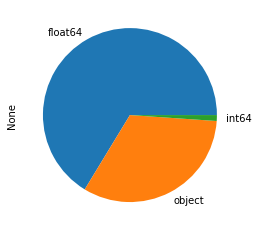

In [8]:
df.dtypes.value_counts().plot.pie()

In [9]:
df.count()

code                  1741534
url                   1741534
creator               1741530
created_t             1741534
created_datetime      1741534
                       ...   
choline_100g               41
phylloquinone_100g       1712
beta-glucan_100g           31
inositol_100g              46
carnitine_100g             20
Length: 184, dtype: int64

In [10]:
df.isnull().sum().sort_values()

code                                           0
url                                            0
created_t                                      0
created_datetime                               0
last_modified_t                                0
                                          ...   
water-hardness_100g                      1741534
no_nutriments                            1741534
allergens_fr                             1741534
cities                                   1741534
ingredients_that_may_be_from_palm_oil    1741534
Length: 184, dtype: int64

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution de NaNs')

Text(0.5, 0, 'NaNs')

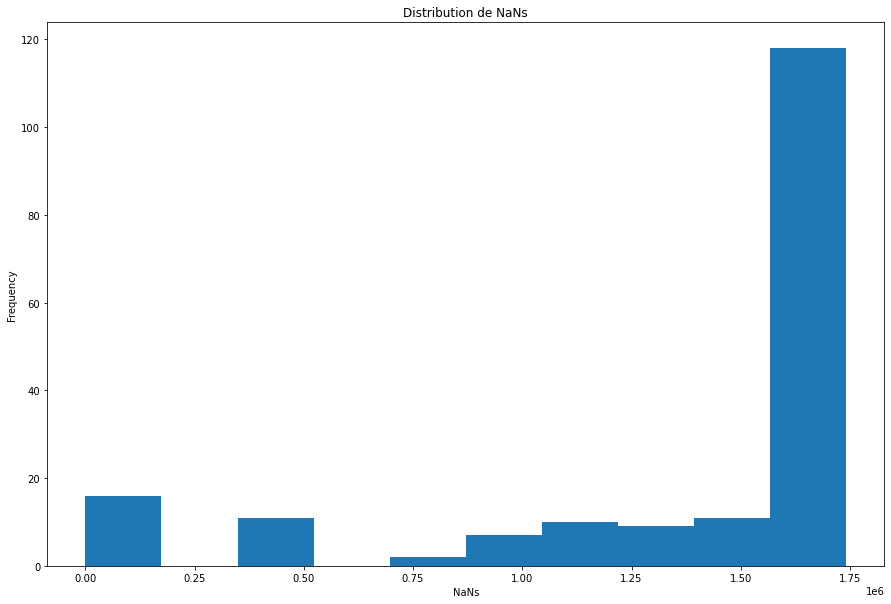

In [11]:
df.isnull().sum().plot(kind='hist', figsize=(15, 10))
plt.title('Distribution de NaNs')
plt.xlabel('NaNs')

plt.show()

### Compréhension des données

#### Aperçu des contributeurs


Les 10 premiers contributeurs (en nombre et en pourcentage)
                          creator  Nombre  Pourcentage
6594                      kiliweb  974818    55.974675
12530             usda-ndb-import  169827     9.751575
9512   openfoodfacts-contributors  162061     9.305647
9558            org-database-usda  134539     7.725316
3574                       elcoco   33179     1.905159
2920              date-limite-app   31189     1.790892
5440                          inf   11513     0.661084
9510           openfood-ch-import   11455     0.657753
11138                    sebleouf   10309     0.591949
10218                  prepperapp    9964     0.572139


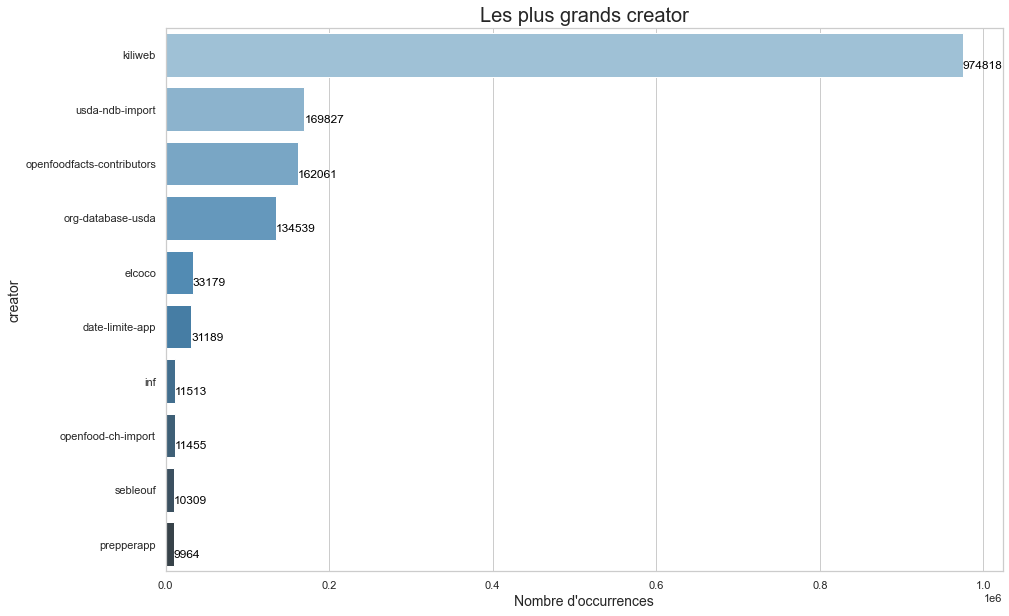

Nombre d'enregistrements vides pour creator: 4 (0.0002296825672079902%)
nunique      13382
count      1741530
size       1741534
Name: creator, dtype: int64


In [12]:
# Get top 10 Contributors
df_10_contributors = get_top_10(df, 'creator')

# Show Result
print('\nLes 10 premiers contributeurs (en nombre et en pourcentage)')
print(df_10_contributors)
show_plot(df_10_contributors, 'creator')

# Show Information about empty records
print_stats(df, 'creator')

Après avoir chargé et explorer légèrement les nous pouvons commencer à identifier qui sont les contributeurs : https://fr.openfoodfacts.org/contributeurs

Pouvons-nous leur faire confiance ? 

Une grande partie des données a été générée par kiliweb. Approximativement 55%. Qui est-ce ?

Kiliweb semble être une agence web en France.

#### Aperçu du moment où les produits ont été créés par les contributeurs

,creator,mod_datetime
0,kiliweb,2018
2,kiliweb,2019
4,openfoodfacts-contributors,2019
5,kiliweb,2018
6,kiliweb,2018
...,...,...
1741528,kiliweb,2020
1741529,kiliweb,2019
1741531,kiliweb,2020
1741532,kiliweb,2021


<AxesSubplot:title={'center':'Quand les produits ont-ils été créés ?'}, xlabel='mod_datetime'>

<AxesSubplot:title={'center':'Quand les produits ont-ils été créés ?'}, xlabel='mod_datetime'>

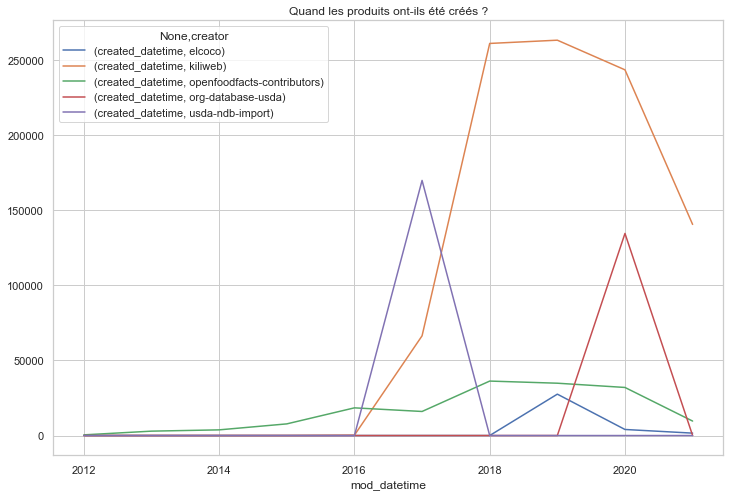

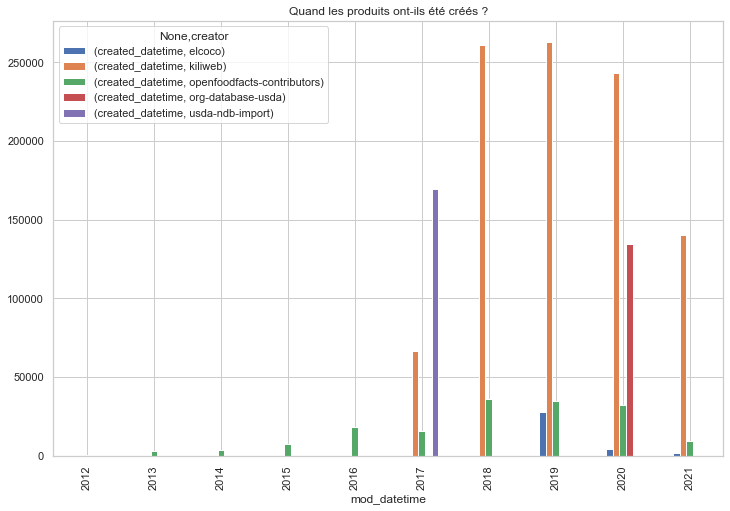

In [13]:
top_5_creators = df.loc[(df['creator'] == 'kiliweb') |
                        (df['creator'] == 'usda-ndb-import') |
                        (df['creator'] == 'openfoodfacts-contributors') |
                        (df['creator'] == 'org-database-usda') |
                        (df['creator'] == 'elcoco')][[
                            'creator', 'created_datetime'
                        ]]

top_5_creators['mod_datetime'] = top_5_creators['created_datetime'].apply(
    lambda x: x[0:4])
top_5_creators.drop('created_datetime', axis=1)

mod_pivot = pd.pivot_table(top_5_creators,
                           index=top_5_creators['mod_datetime'],
                           columns='creator',
                           aggfunc=len,
                           fill_value=0)
mod_pivot.plot(kind="line",
               figsize=(12, 8),
               title="Quand les produits ont-ils été créés ?")
mod_pivot.plot(kind="bar",
               figsize=(12, 8),
               title="Quand les produits ont-ils été créés ?")

Jusqu'à présent, nous pouvons voir que Kiliweb est le contributeur le plus actif et ajoute continuellement des produits. C'est le contributeur le plus actif. La plupart des produits sont donc probablement principalement de France. 
Nous pouvons déjà supposer, sur la base des principaux contributeurs, que les produits français prédominent.

usda-ndb-import, qui est le 'United States Department of Agriculture' semble ne plus contribuer à la base de données open food facts et n'a été importé qu'une seule fois.

La communauté ouverte des contributeurs d'openfoodfacts semble s'agrandir au fil des années. La diversité des contributeurs peut conduire à des données non concordantes.

#### Les marques
Informations générales sur les marques


Les 10 premières marques (nombres et pourcentages)
              brands  Nombre  Pourcentage
20495      Carrefour   14320     0.822264
7410          Auchan   11241     0.645465
15064        Bonarea    6960     0.399648
127017             U    6185     0.355147
31793       Delhaize    4995     0.286816
52197      Hacendado    4904     0.281591
21246         Casino    4502     0.258508
90856         Nestlé    4340     0.249206
71810   Leader Price    4204     0.241396
27020           Coop    3469     0.199192


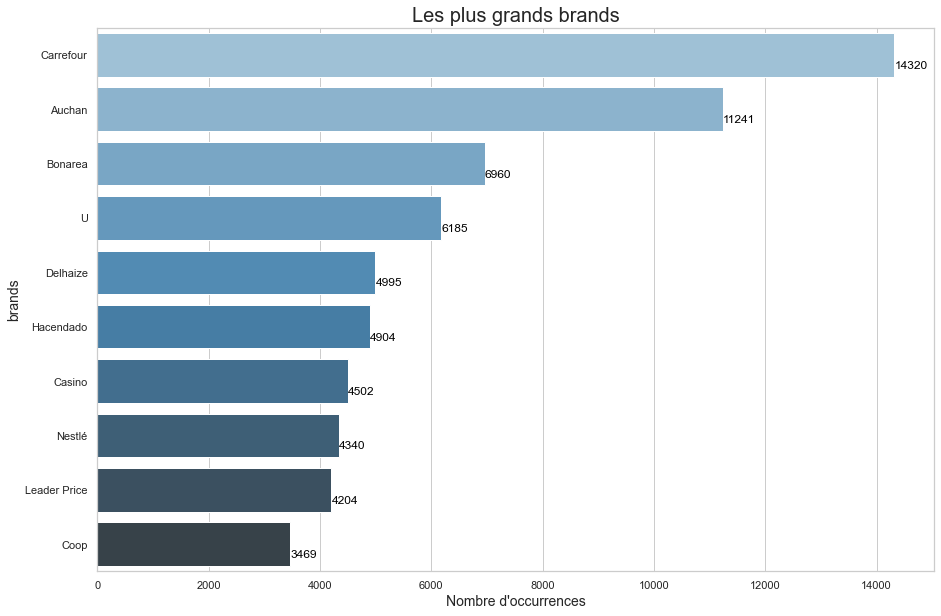

Nombre d'enregistrements vides pour brands: 832771 (47.8182452940913%)
nunique     160641
count       908763
size       1741534
Name: brands, dtype: int64


In [14]:
# Obtenir le top 10 des marques
df_10_brands = get_top_10(df, 'brands')

# Afficher le résultat
print('\nLes 10 premières marques (nombres et pourcentages)')
print(df_10_brands)
show_plot(df_10_brands, 'brands')

# Afficher des informations sur les enregistrements vides
print_stats(df, 'brands')

48% des produits ne sont associés à aucune marque. En outre, les 6 plus grandes marques d'Open Food Facts sont Français.

Il semble que, comme décrit ci-dessus avec les contributeurs, la communauté française, à travers kiliweb, est le contributeur le plus important. Cela peut expliquer pourquoi il y a tant de produits assignés à la France.


Top 10 countries (Counts & Percentage)
          countries_fr  Nombre  Pourcentage
2215            France  719896    41.336890
3987        États-Unis  343086    19.700218
2092           Espagne  196916    11.307043
3193            Italie   61439     3.527867
123          Allemagne   59186     3.398498
972           Belgique   47760     2.742410
3758            Suisse   45303     2.601327
3557       Royaume-Uni   38649     2.219250
1741            Canada   27515     1.579929
2219  France,Allemagne   11781     0.676473


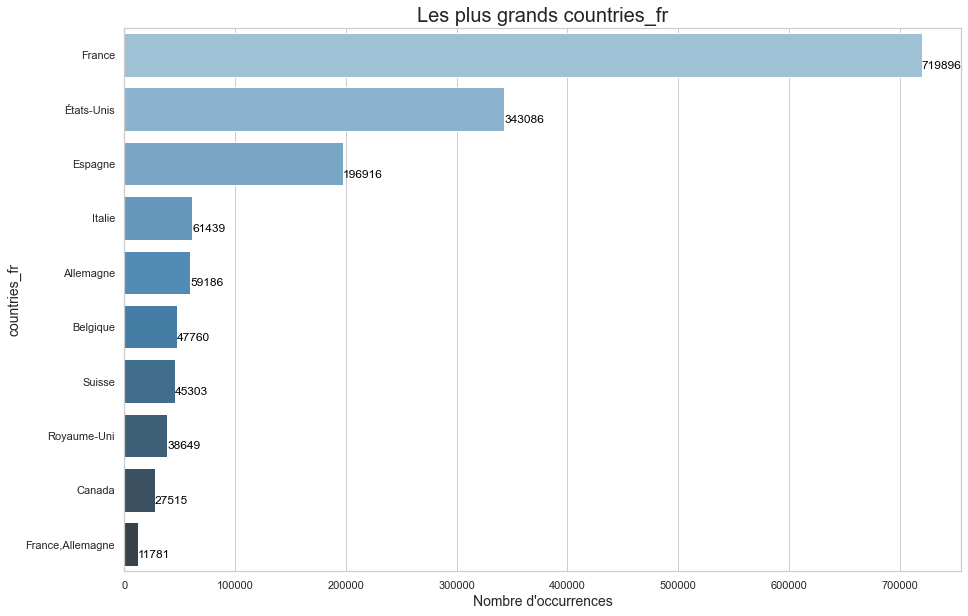

Nombre d'enregistrements vides pour countries_fr: 5482 (0.31477995835855055%)
nunique       4005
count      1736052
size       1741534
Name: countries_fr, dtype: int64


In [15]:
# Obtenir le top 10 de countries_fr
df_10_countries_fr = get_top_10(df, 'countries_fr')

# Afficher le résultat
print('\nTop 10 countries (Counts & Percentage)')
print(df_10_countries_fr)
show_plot(df_10_countries_fr, 'countries_fr')

# Afficher des informations sur les NaNs
print_stats(df, 'countries_fr')

Nous découvrons ici le même comportement que l'analyse précédente. La plupart des produits sont attribués à la France, ce qui était attendu puisque le principal contributeur est kiliweb une agence web française. Ceci est cohérent, surtout après l'analyse des contributeurs et des marques ci-dessus.

Même si la plupart des produits ont été assignés à un pays, 5482 produits ne sont liés à aucun pays et qu'il y a 4005 pays.

Jusqu'à présent, il semble que les pays contiennent une liste de pays et non un pays unique comme en témoigne la 10e ligne "France,Allemagne".

De plus, la plupart des produits sont liés à un ou deux pays seulement, ce qui est très suspect. Nous pourrions par exemple supposer sans le moindre doute que cette confiture à la fraise de l'Oregon https://fr.openfoodfacts.org/produit/0011110901422/oregonstrawberry-kroger attribué à la France a été fondée aux USA puisque c'est là où se situe l'Oregon et qu'il est fabriqué par Kroger https://fr.wikipedia.org/wiki/Kroger.

<img src="https://static.openfoodfacts.org/images/products/001/111/090/1422/front_fr.4.full.jpg"></img>

Très probablement, ce produit est vendu en France et a été répertorié comme produit français. Mais nous pouvons être sûrs que cette confiture est également vendu aux Etats-Unis, peut-être sous un autre nom de produit.

Jusqu'à présent, nous pouvons conclure que ce champ pays doit être utilisé avec précaution pour fournir une analyse de produits français ou vendu en France aux agents de Santé Publique France.

### Cartographie

Même si les informations sur les Pays ne sont pas bien structurées, nous pouvons procéder à quelques activités de nettoyage. 

Dans ce but, allons essayer de créer une carte avec folium, nous proposons les étapes suivantes :
- Charger un fichier contenant une liste de pays et le code iso à trois lettres.
- Nettoyage/analyse du nom du pays à partir de openFoodFacts, si nécessaire, certains synonymes doivent être identifiés. (nous pouvons rechercher si une liste de synonymes peut être fondée. A ce stade, pour cet exercice, nous avons décidé de créer notre propre liste).
- Cartographier le pays normalisé avec un nom de pays correct.
- Montrer une carte du folium et mettre en correspondance la valeur avec les codes iso à 3 lettres et récupérer le pourcentage en conséquence.

#### Fonctions pour la cartographie

In [22]:
def get_percentage_from_country(country_name, df_countries):
    try:
        perc = df_countries.loc[country_name]['percentage']
        return float(perc)

    except:
        return float(0)
        pass


def get_country_map_color(country_iso3166):

    # Obtenir le nom du pays depuis df_countries
    country_name = df_countries.loc[country_iso3166]['Country']
    perc = get_percentage_from_country(country_name, df_10_countries_fr)

    if (perc == 0):
        color = '#FFFFFF'
    elif (perc < 10):
        color = '#D1E2F3'
    elif (perc < 20):
        color = '#83B6D5'
    elif (perc < 30):
        color = '#3074B0'
    elif (perc < 40):
        color = '#1A519C'
    elif (perc >= 40):
        color = '#0B143D'

    if (perc > 0):
        print(country_iso3166 + '-' + country_name + ' - perc:' + str(perc) +
              'color:' + color)

    return color

In [17]:
# https://www.kaggle.com/juanumusic/countries-iso-codes
df_countries = pd.read_csv(data_path + 'wikipedia-iso-country-codes.csv',
                           sep=";",
                           low_memory=False,
                           skiprows=0)
df_countries.set_index("Alpha-3", inplace=True)
df_countries.head(5)

,Country,Alpha-2,Numeric
Alpha-3,,,
AFG,Afghanistan,AF,4
ZAF,Afrique du Sud,ZA,710
ALA,Aland (Îles),AX,248
ALB,Albanie,AL,8
DZA,Algérie,DZ,12


In [19]:
df_10_countries_fr.set_index('countries_fr', inplace=True)

In [23]:
# https://github.com/datasets/geo-countries/
countries_geojson = json.load(open(data_path + 'countries.geojson'))

# countries_geojson

countries_map = folium.Map([46, 8], tiles='cartodbpositron', zoom_start=2)
folium.GeoJson(countries_geojson,
               style_function=lambda country: {
                   'fillColor': get_country_map_color(country['id']),
                   'color': 'gray',
                   'weight': 1,
                   'dashArray': '1, 1',
                   'lineOpacity': 0.2,
                   'fillOpacity': 0.9
               }).add_to(countries_map)

print('\nPays le plus important en pourcentage de produits\n\n')
countries_map


Pays le plus important en pourcentage de produits





Top 10 des origines (nombres et pourcentages)
               origins  Nombre  Pourcentage
3267            France   18902     1.085365
6058            México    1886     0.108295
8875  Union Européenne    1603     0.092045
2709            España    1450     0.083260
4877            Italie    1332     0.076484
2638           Espagne    1242     0.071316
2235       Deutschland    1076     0.061785
8951  Union européenne     988     0.056732
4989             Italy     809     0.046453
4848            Italia     807     0.046338


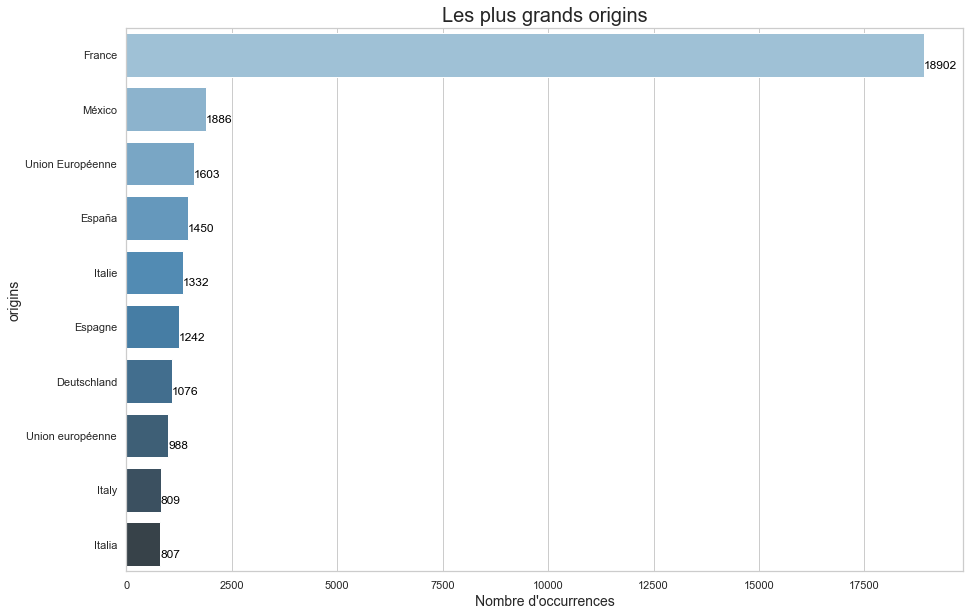

Nombre d'enregistrements vides pour origins: 1666001 (95.66284666276972%)
nunique      12389
count        75533
size       1741534
Name: origins, dtype: int64


In [25]:
# Obtenir le top 10 des origines
df_10_origins = get_top_10(df, 'origins')

# Afficher le résultat
print('\nTop 10 des origines (nombres et pourcentages)')
print(df_10_origins)
show_plot(df_10_origins, 'origins')

# Afficher des informations sur les enregistrements vides
print_stats(df, 'origins')

Les origines sont très dénormalisées et peuvent contenir comme valeur un pays une région ou un continent,... 12389 valeurs uniques, c'est beaucoup plus que la liste des pays potentiels.

Cela rend l'utilisation de ce champ difficile.

#### Catégorie principale

Nous cherchons à savoir quelles sont les principales catégories (nombre/pourcentage/NaNs).


Top 10 des principales catégories (nombres et pourcentages)
          main_category_fr  Nombre  Pourcentage
13764               Snacks   32884     1.888220
13040               Sauces   16013     0.919477
3575           Confiseries   15262     0.876354
5866              Fromages   14652     0.841327
1142              Biscuits   14638     0.840523
1609              Boissons    9314     0.534816
4665       Desserts glacés    9238     0.530452
9838                 Pains    8999     0.516728
22489     en:salted-snacks    7684     0.441220
4467   Céréales et dérivés    7402     0.425028


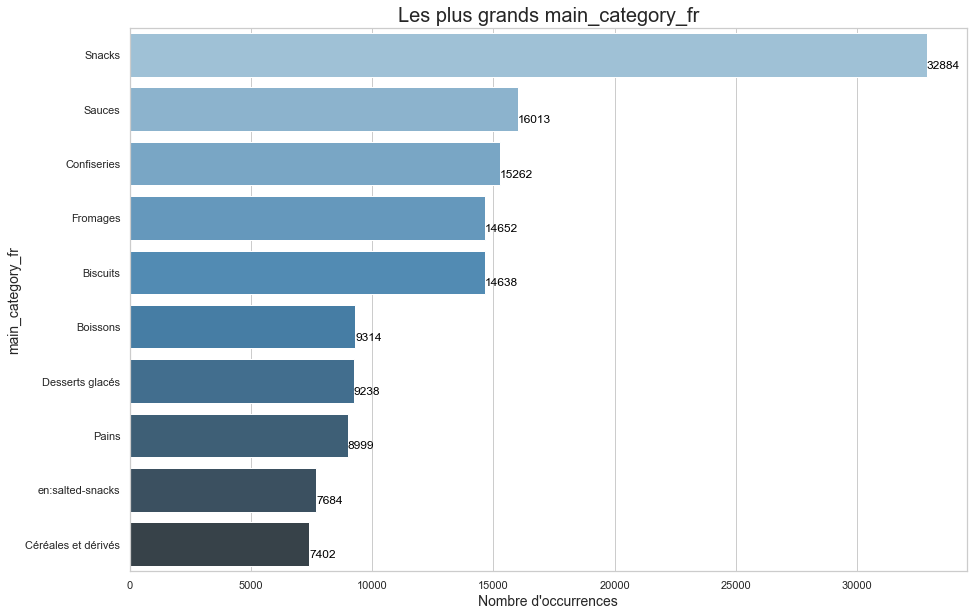

Nombre d'enregistrements vides pour main_category_fr: 905960 (52.0208046469377%)
nunique      28838
count       835574
size       1741534
Name: main_category_fr, dtype: int64


In [27]:
# Obtenir le top 10 Catégorie principale
df_10_main_category_fr = get_top_10(df, 'main_category_fr')

# Show Result
print('\nTop 10 des principales catégories (nombres et pourcentages)')
print(df_10_main_category_fr)
show_plot(df_10_main_category_fr, 'main_category_fr')

# Afficher des informations sur les enregistrements vides
print_stats(df, 'main_category_fr')

Il semble que 52% des produits n'ont pas de catégorie.

#### Anomalies

Nous cherchons à savoir s'il y a d'autres anomalies dans les données. Nous examinons la qualité des données pour comprendre ce qui pourrait être utilisé pour une analyse plus approfondie.

In [32]:
df[df.duplicated(subset='code')].head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
633814,30383354190402,http://world-fr.openfoodfacts.org/produit/3038...,openfoodfacts-contributors,1608035756,2020-12-15T12:35:56Z,1610702583,2021-01-15T09:23:03Z,basilic,NaN,NaN,...,NaN,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1015382,3770008983205,http://world-fr.openfoodfacts.org/produit/3770...,r-x,1614201389,2021-02-24T21:16:29Z,1614242412,2021-02-25T08:40:12Z,REMYX VODKA Aquatique,NaN,Vodka,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1324219,7340011495437,http://world-fr.openfoodfacts.org/produit/7340...,halal-app-chakib,1610378294,2021-01-11T15:18:14Z,1610393709,2021-01-11T19:35:09Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1389391,7798049540559,http://world-fr.openfoodfacts.org/produit/7798...,openfoodfacts-contributors,1615222625,2021-03-08T16:57:05Z,1615337611,2021-03-10T00:53:31Z,lentejas,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous avons identifié quelques doublons comme indiqué ci-dessus, qui devraient être nettoyés/supprimés, une fois clairement identifiés.

### Nettoyage des données

Cette partie, contient toutes les activités de nettoyage des données, effectuées sur le fichier fr.openfoodfacts.org.products.csv. Le but de cette partie est de nettoyer les données et de les enrichir en fonction des activités requises. Qui est, pour rappel, fournir des données de santé plus accessible.

Pour effectuer ce nettoyage de données, nous avons décidé de :

1 Nettoyer les noms des produits

Avant d'effectuer toute analyse, il est en effet important de disposer d'un ensemble de données consolidées correctes. En effet, nous découvrons que l'ensemble de données nécessite beaucoup d'activités de nettoyage et que la qualité des données est parfois médiocre. Peut-être il nous serait préférable de nous concentrer sur les principaux collaborateurs...

In [36]:
# Nous gardons toutes les colonnes que nous jugeons intéressantes et que nous
# avons l'intention d'utiliser pour notre enquête.
useful_columns = [
    'code', 'url', 'creator', 'created_t', 'created_datetime',
    'last_modified_t', 'product_name', 'brands', 'brands_tags',
    'main_category_fr', 'categories_fr', 'origins', 'countries_fr',
    'ingredients_text', 'quantity', 'serving_size', 'serving_quantity',
    'additives_fr', 'sugars_100g', 'salt_100g', 'fat_100g', 'sodium_100g',
    'energy_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'
]

In [37]:
df_clean = df[useful_columns]
df_clean.head()

,code,url,creator,created_t,created_datetime,last_modified_t,product_name,brands,brands_tags,main_category_fr,...,serving_size,serving_quantity,additives_fr,sugars_100g,salt_100g,fat_100g,sodium_100g,energy_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000000017,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,Vitória crackers,NaN,NaN,NaN,...,NaN,NaN,NaN,15.0,1.4,7.0,0.56,1569.0,NaN,NaN
1,0000000000031,http://world-fr.openfoodfacts.org/produit/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,Cacao,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,Filetes de pollo empanado,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000100,http://world-fr.openfoodfacts.org/produit/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,moutarde au moût de raisin,courte paille,courte-paille,Moutardes,...,NaN,NaN,NaN,22.0,4.6,8.2,1.84,936.0,18.0,NaN
4,00000000001111111111,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,Sfiudwx,Watt,watt,Xsf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Supression

Suppression de tous les produits qui n'ont pas de nom de produit, de catégorie et de marque.

##### Fonctions

La fonction fill_nans remplace toutes les valeurs vides pour product_name, brands_tag et categories_fr.

In [38]:
def fill_nans(df):
    df.product_name.fillna('', inplace=True)
    df.brands_tags.fillna('', inplace=True)
    df.categories_fr.fillna('', inplace=True)

    return df

La fonction show_empty_product montre tous les produits qui n'ont aucun nom de produit, catégorie et marque

In [39]:
def show_empty_product(df_clean):

    df['is_valid'] = ((df.product_name.str.len() + df.categories_fr.str.len() +
                       df.brands_tags.str.len()) > 0)
    df['is_valid']

    df_to_clean = df.query('is_valid==0')

    print('Produits sans nom de produit, catégorie et marques: ' +
          str(df_to_clean.shape[0]))
    print(df_to_clean[['code', 'product_name', 'brands',
                       'categories_fr']].head(10))

In [40]:
df_clean = fill_nans(df_clean)
show_empty_product(df_clean)

Produits sans nom de produit, catégorie et marques: 1148662
                  code                   product_name brands categories_fr
0        0000000000017               Vitória crackers    NaN           NaN
1        0000000000031                          Cacao    NaN           NaN
2   000000000003327986      Filetes de pollo empanado    NaN           NaN
5        0000000000123          Sauce Sweety chili 0%    NaN           NaN
6        0000000000178                      Mini coco    NaN           NaN
7        0000000000208          Pistou d'ail des ours    NaN           NaN
8        0000000000284                      Pain maïs    NaN           NaN
9        0000000000291                      Mendiants    NaN           NaN
10        000000000054  Limonade artisanale a la rose    NaN           NaN
11        000000000075                Sachet calisson    NaN           NaN


___________________________________________________________

In [ ]:
# Nous supprimons toutes les colonnes contenant moins de 20% de données utilisables
df = df.dropna(axis=1, thresh=len(df) * 0.2, how='all')

In [ ]:
# Supprimer toutes les lignes qui (après avoir supprimé certaines colonnes) ne contiennent que des NaN
df = df.dropna(axis=0, how='all')

In [ ]:
print(
    f'Il y a maintenant {df.shape[0]} lignes et {df.shape[1]} colonnes restantes dans nos données'
)

In [ ]:
df.isnull().sum().sort_values()

In [ ]:
plt.figure(figsize=(30, 20))
sns.heatmap(df.isna(), cbar=False)

In [ ]:
print(
    f'Il y a maintenant {df.shape[0]} lignes et {df.shape[1]} colonnes restantes dans nos données'
)

In [ ]:
df.columns

In [ ]:
df.duplicated().sum()

In [ ]:
df.dtypes

In [ ]:
df['created_datetime'] = pd.to_datetime(df['created_datetime'],
                                        format='%Y-%m-%dT%H:%M:%SZ',
                                        errors='coerce')

In [ ]:
df['last_modified_datetime'] = pd.to_datetime(df['last_modified_datetime'],
                                              format='%Y-%m-%dT%H:%M:%SZ',
                                              errors='coerce')

In [ ]:
df[['created_datetime', 'last_modified_datetime']].isnull().sum()

In [ ]:
# Nous remplissons les NaNs
df['created_datetime'].fillna(method='ffill', inplace=True)
df['last_modified_datetime'].fillna(method='ffill', inplace=True)

In [ ]:
df.describe()

Une inspection plus approfondie des valeurs min et max révèle qu'il y a des erreurs évidentes dans nos données.

In [ ]:
df.select_dtypes(include=float).plot(
    kind='box',
    subplots=True,
    title="Nos données avant l'élimination des valeurs aberrantes",
    figsize=(20, 20),
    layout=(6, 4))

plt.show()

In [ ]:
sns.pairplot(df,
             x_vars=['nutrition-score-fr_100g'],
             y_vars=['nutrition-score-uk_100g'],
             height=5)

plt.show()

Nous allons maintenant éliminer toutes les lignes, qui contiennent des valeurs impossibles par définition.

In [ ]:
df = df[(df['fat_100g'] + df['carbohydrates_100g'] +
         df['proteins_100g']) <= 100]

In [ ]:
df.describe()

In [ ]:
df.select_dtypes(include=float).plot(
    kind='box',
    subplots=True,
    title='Nos données après élimination des valeurs aberrantes',
    figsize=(20, 20),
    layout=(6, 4))

plt.show()

# Pré-traitement des données

Suppression des colonnes non nécessaire

# Résultats

# Conclusions et prochaines étapes